In [1]:
import pandas as pd
import numpy as np
import sys,os
import matplotlib.pyplot as plt

pd.options.display.max_rows = 10

# Ch10. 데이터 집계와 그룹 연산

## 10.1. GroupBy 메카닉  
분리 - 적용 - 결합 (split-apply-combine)

In [2]:
df = pd.DataFrame({
    'key1':['a','a','b','b','a'],
    'key2':['one','two','one','two','one'],
    'data1':np.random.randn(5),
    'data2':np.random.randn(5),
})
df

,key1,key2,data1,data2
0,a,one,0.298637,0.540580
1,a,two,0.545054,0.237445
2,b,one,-0.495015,0.638649
3,b,two,1.555184,1.640991
4,a,one,-1.237120,0.736395


위 데이터를 key1으로 묶고 각 그룹에서 data1의 평균을 구하기  
groupby 메서드를 호출하면됨

In [3]:
df['data1'].groupby(df['key1'])
grouped = df['data1'].groupby(df['key1'])

GroupBy 객체는 key1으로 참조되는 중간값에 대한것 외에는 아무것도 계산되지 않은 객체임  
그룹연산에 필요한 모든 정보를 포함하고 있어, 각 그룹에 연산을 적용할수 있게함

In [4]:
grouped.sum()
grouped.mean()

key1
a   -0.393429
b    1.060169
Name: data1, dtype: float64

key1
a   -0.131143
b    0.530084
Name: data1, dtype: float64

데이터가 그룹색인에 따라 수집되고 key1컬럼의 유니크한 값으로 색인되는 새로운 Series 객체가 생성됨

여러개의 배열을 넘기면 계층 색인을 가지는 Series가 나옴

In [5]:
means = df['data1'].groupby([df['key1'],df['key2']]).mean()
means

key1  key2
a     one    -0.469241
      two     0.545054
b     one    -0.495015
      two     1.555184
Name: data1, dtype: float64

groupby에 넘기는 객체는 길이만 같으면 어떤것도 상관없음

In [6]:
states = np.array(['Ohio','California','California','Ohio','Ohio'])
years = np.array([2005,2005,2006,2005,2006])
df['data1'].groupby([states,years]).mean()

California  2005    0.545054
            2006   -0.495015
Ohio        2005    0.926910
            2006   -1.237120
Name: data1, dtype: float64

한 그룹으로 묶을 정보를 같은 DataFrame안에서 찾을 경우 컬럼이름을 넘겨서 사용할수 있음

In [7]:
df.groupby('key1').mean()
'''key2의 경우 숫자데이터가 아니기 때문에 (성가신컬럼,nuisance column)결과에서 제외됨'''
df.groupby(['key1','key2']).mean()

,data1,data2
key1,,
a,-0.131143,0.504806
b,0.530084,1.139820


'key2의 경우 숫자데이터가 아니기 때문에 (성가신컬럼,nuisance column)결과에서 제외됨'

data1     data2
key1 key2                    
a    one  -0.469241  0.638487
     two   0.545054  0.237445
b    one  -0.495015  0.638649
     two   1.555184  1.640991

GroupBy 메서드 중 size메서드는 그룹의 크기를 돌려주므로 유용함

In [8]:
df.groupby(['key1','key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

### 10.1.1 그룹간 순회하기  
groupby 객체는 이터레이션을 지원함  
그룹이름과 그에 따른 데이터 묶음을 반환

In [9]:
for name,data in df.groupby('key1'):
    print(name)
    print(data)
    print('--------------')

a
  key1 key2     data1     data2
0    a  one  0.298637  0.540580
1    a  two  0.545054  0.237445
4    a  one -1.237120  0.736395
--------------
b
  key1 key2     data1     data2
2    b  one -0.495015  0.638649
3    b  two  1.555184  1.640991
--------------


In [10]:
#색인이 여러개일 경우 튜플의 첫번째 원소가 색인값이됨
for k,group in df.groupby(['key1','key2']):
    print(k)
    print(group)

('a', 'one')
  key1 key2     data1     data2
0    a  one  0.298637  0.540580
4    a  one -1.237120  0.736395
('a', 'two')
  key1 key2     data1     data2
1    a  two  0.545054  0.237445
('b', 'one')
  key1 key2     data1     data2
2    b  one -0.495015  0.638649
('b', 'two')
  key1 key2     data1     data2
3    b  two  1.555184  1.640991


In [11]:
#쪼갠데이터를 사전에 넣어쓰기
pieces = dict(list(df.groupby('key1')))
pieces
pieces['a']

{'a':   key1 key2     data1     data2
 0    a  one  0.298637  0.540580
 1    a  two  0.545054  0.237445
 4    a  one -1.237120  0.736395, 'b':   key1 key2     data1     data2
 2    b  one -0.495015  0.638649
 3    b  two  1.555184  1.640991}

,key1,key2,data1,data2
0,a,one,0.298637,0.540580
1,a,two,0.545054,0.237445
4,a,one,-1.237120,0.736395


기본적으로 axis=0 으로 그룹을 만들지만 다른축도 가능함,  
데이터 타입에 따라 쪼개기

In [12]:
df.dtypes
grouped = df.groupby(df.dtypes,axis=1)
for k,data in grouped:
    print(k,'\n',data)

key1      object
key2      object
data1    float64
data2    float64
dtype: object

float64 
       data1     data2
0  0.298637  0.540580
1  0.545054  0.237445
2 -0.495015  0.638649
3  1.555184  1.640991
4 -1.237120  0.736395
object 
   key1 key2
0    a  one
1    a  two
2    b  one
3    b  two
4    a  one


### 10.1.2 컬럼이나 컬럼의 일부만 선택하기

In [13]:
df['data1'].groupby(df['key1'])
df[['data2']].groupby(df['key1'])

In [14]:
#신택틱 슈거
df.groupby('key1')['data1']
df.groupby('key2')[['data2']]

array를 넘기면 DF로, 단일값을 넘기면 series

In [15]:
df.groupby(['key1','key2'])[['data1']].mean()
df.groupby(['key1','key2'])['data1'].mean()

data1
key1 key2          
a    one  -0.469241
     two   0.545054
b    one  -0.495015
     two   1.555184

key1  key2
a     one    -0.469241
      two     0.545054
b     one    -0.495015
      two     1.555184
Name: data1, dtype: float64

### 10.1.3. 사전과 Series에서 그루핑하기

In [16]:
people = pd.DataFrame(np.random.randn(5,5),
                     columns = list('abcde'),
                     index = ['Joe','Steve','Wes','Jim','Travis'])
people.iloc[2:3,[1,2]] = np.nan
people

,a,b,c,d,e
Joe,-2.119057,-1.089002,-0.769806,0.127241,-2.461925
Steve,-0.212185,-0.542922,-0.191025,1.789443,-0.110754
Wes,-0.310219,NaN,NaN,2.690639,-0.043628
Jim,0.196210,0.448961,0.387596,-0.319477,-0.152522
Travis,-0.170575,-1.000746,0.556796,-1.400273,-1.395692


컬럼에 매핑되는 새로운 그룹이 있고, 그룹별로 더하기

In [17]:
mapping={
    'a':'red',
    'b':'red',
    'c':'blue',
    'd':'blue',
    'e':'red',
    'f':'orange'  #사용하지 않는 그룹키도 문제없음
}

by_col = people.groupby(mapping,axis=1)
by_col.sum()

,blue,red
Joe,-0.642565,-5.669984
Steve,1.598419,-0.865860
Wes,2.690639,-0.353846
Jim,0.068120,0.492650
Travis,-0.843476,-2.567013


In [18]:
map_series = pd.Series(mapping)
map_series
people.groupby(map_series,axis=1).count()

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


### 10.1.4 함수로 그루핑하기  
사전이나 Series를 이용하는것 보다 파이썬 함수를 이용하는것이 조금더 일반적임  
넘긴 함수는 색인값 하나마다 한번씩 호출됨

이름 길이가 같은 놈끼리 묶으려면..

In [19]:
a = people.groupby(len,axis=0)
[t[0] for t in a]
a.sum()

[3, 5, 6]

,a,b,c,d,e
3,-2.233065,-0.640041,-0.382210,2.498403,-2.658075
5,-0.212185,-0.542922,-0.191025,1.789443,-0.110754
6,-0.170575,-1.000746,0.556796,-1.400273,-1.395692


내부적으로 모두 배열로 변환되므로 함수와 다른것을 섞어도 문제가 안됨  
각 색인별로 함수를 한번씩 적용한 리턴값이 새로운 색인이됨

In [20]:
key_list = ['one','one','one','two','two']

people.groupby([len,key_list]).mean()

a         b         c         d         e
3 one -1.214638 -1.089002 -0.769806  1.408940 -1.252776
  two  0.196210  0.448961  0.387596 -0.319477 -0.152522
5 one -0.212185 -0.542922 -0.191025  1.789443 -0.110754
6 two -0.170575 -1.000746  0.556796 -1.400273 -1.395692

### 10.1.5 색인 단계로 그루핑하기  
계층색인에서 하나를 선택하기 위한 기능

In [21]:
columns = pd.MultiIndex.from_arrays([['US','US','US','JP','JP'],
                                   [1,3,5,1,3]],names=['cty','tenor'])
hier_df = pd.DataFrame(np.random.randn(4,5), columns = columns)
hier_df
hier_df.groupby(level='cty',axis=1).count()

cty          US                            JP          
tenor         1         3         5         1         3
0      0.570811  0.727645  1.839486 -0.686578 -0.332594
1      1.073922 -0.291388  0.135358  1.004986 -0.168057
2      0.459299  0.747826 -1.735721  1.677653 -0.538048
3      1.586375 -1.321160 -1.214933  0.043025 -0.962739

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


## 10.2. 데이터 집계  
배열로부터 스칼라값을 만들어 내는 모든 데이터 변환 작업을 말함  
- count,sum,mean,median,std,var,min,max,prod,first,last 등등

GroupBy 메서드는 아니지만 Series메서드인 quantile등도 사용가능

In [22]:
df.groupby('key1')['data1'].quantile(0.9)

key1
a    0.495771
b    1.350164
Name: data1, dtype: float64

직접 만든 집계함수를 사용할수도 있음  
- aggregate나 agg 메서드에 함수를 넘기면됨

In [23]:
def peak_to_peak(arr):
    return arr.max() - arr.min()
df.groupby('key1').agg(peak_to_peak)

,data1,data2
key1,,
a,1.782174,0.498949
b,2.050198,1.002342


In [24]:
df.groupby('key1').describe()

data1                                                              \
     count      mean       std       min       25%       50%       75%   
key1                                                                     
a      3.0 -0.131143  0.965696 -1.237120 -0.469241  0.298637  0.421845   
b      2.0  0.530084  1.449709 -0.495015  0.017535  0.530084  1.042634   

               data2                                                   \
           max count      mean       std       min       25%      50%   
key1                                                                    
a     0.545054   3.0  0.504806  0.251391  0.237445  0.389012  0.54058   
b     1.555184   2.0  1.139820  0.708763  0.638649  0.889235  1.13982   

                          
           75%       max  
key1                      
a     0.638487  0.736395  
b     1.390406  1.640991

사용자 정의 함수는 일반적으로 GroupBy함수보다 매우 느린데, 중간 데이터를 행성하는 과정에서 호출이나 정렬같은 오버헤드가 발생하기 때문

### 10.2.1. 컬럼에 여러가지 함수 적용하기

In [25]:
tips = pd.read_csv('Datas/tips.csv')
tips['tip_pct'] = tips['tip']/tips['total_bill']
tips.head()

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808


In [26]:
tips.aggregate(np.mean)

total_bill    19.785943
tip            2.998279
size           2.569672
tip_pct        0.160803
dtype: float64

모든 컬럼을 집계하는것은 mean등의 메서드를 사용하거나 원하는 함수에 aggregate를 사용하면되지만  
컬럼에 따라 다른 함수를 사용해서 집계를 수행하거나, 여러개의 함수를 한번에 적용하려면 다음과 같이..

In [27]:
#tips를 day와 smoker로 묶기
grouped = tips.groupby(['day','smoker'])
grouped_pct = grouped['tip_pct']
#groupby 메서드의 경우 문자열로 넘김
#grouped_pct.mean()
grouped_pct.agg('mean')

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

함수 목록이나 함수 이름을 넘기면 함수 이름을 컬럼으로 하는 DataFrame을 얻음

In [28]:
grouped_pct.agg(['mean','std','count',peak_to_peak,lambda x:'람다! {}'.format(len(x))])

mean       std  count  peak_to_peak <lambda>
day  smoker                                                  
Fri  No      0.151650  0.028123      4      0.067349    람다! 4
     Yes     0.174783  0.051293     15      0.159925   람다! 15
Sat  No      0.158048  0.039767     45      0.235193   람다! 45
     Yes     0.147906  0.061375     42      0.290095   람다! 42
Sun  No      0.160113  0.042347     57      0.193226   람다! 57
     Yes     0.187250  0.154134     19      0.644685   람다! 19
Thur No      0.160298  0.038774     45      0.193350   람다! 45
     Yes     0.163863  0.039389     17      0.151240   람다! 17

함수의 결과값을 따로 지정해 줄수 있음  
[(컬럼이름1, 함수1),(컬럼이름2,함수2)...]

In [29]:
grouped_pct.agg([('평균','mean'),('표준편차','std'),('갯수','count'),('P2P',peak_to_peak),('람다',lambda x:'람다! {}'.format(len(x)))])

평균      표준편차  갯수       P2P      람다
day  smoker                                          
Fri  No      0.151650  0.028123   4  0.067349   람다! 4
     Yes     0.174783  0.051293  15  0.159925  람다! 15
Sat  No      0.158048  0.039767  45  0.235193  람다! 45
     Yes     0.147906  0.061375  42  0.290095  람다! 42
Sun  No      0.160113  0.042347  57  0.193226  람다! 57
     Yes     0.187250  0.154134  19  0.644685  람다! 19
Thur No      0.160298  0.038774  45  0.193350  람다! 45
     Yes     0.163863  0.039389  17  0.151240  람다! 17

DataFrame은 컬럼마다 다른 함수를 적용하거나, 여러개의 함수를 모든 컬럼에 적용할 수 있다.

In [30]:
functions=['count','mean','max']
result = grouped['tip_pct','total_bill'].agg(functions)
result

tip_pct                     total_bill                  
              count      mean       max      count       mean    max
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

아래처럼 concat으로 이어붙이는것이랑 같은결과

In [31]:
a = grouped['tip_pct'].agg(functions)
b = grouped['total_bill'].agg(functions)
pd.concat([a,b],axis=1,keys=['tip_pct','total_bill'])

tip_pct                     total_bill                  
              count      mean       max      count       mean    max
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

In [32]:
functions=[('갯수','count'),('평균','mean'),('최대값','max')]
result = grouped['tip_pct','total_bill'].agg(functions)
result

tip_pct                     total_bill                  
                 갯수        평균       최대값         갯수         평균    최대값
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

**컬럼마다 다른 함수를 적용하고 싶다면 agg메서드에 컬럼 이름에 대응하는 함수가 들어 있는 사전을 넘기면됨**

In [33]:
grouped.agg({'tip':np.max,'size':'sum'})

tip  size
day  smoker             
Fri  No       3.50     9
     Yes      4.73    31
Sat  No       9.00   115
     Yes     10.00   104
Sun  No       6.00   167
     Yes      6.50    49
Thur No       6.70   112
     Yes      5.00    40

In [34]:
grouped.agg({'tip_pct':['mean','max','std'],'size':'sum'})

tip_pct                     size
                 mean       max       std  sum
day  smoker                                   
Fri  No      0.151650  0.187735  0.028123    9
     Yes     0.174783  0.263480  0.051293   31
Sat  No      0.158048  0.291990  0.039767  115
     Yes     0.147906  0.325733  0.061375  104
Sun  No      0.160113  0.252672  0.042347  167
     Yes     0.187250  0.710345  0.154134   49
Thur No      0.160298  0.266312  0.038774  112
     Yes     0.163863  0.241255  0.039389   40

### 10.2.2 색인되지 않은 형태로 집계된 데이터 반환하기  
as_index=False

In [35]:
tips.groupby(['day','smoker'],as_index=False).mean()

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


reset_index로 빼도 되지만 옵션을 쓰는게 불필요한 연산이 덜들어감

## 10.3. Apply : 일반적인 분리-적용-병합  
apply 메서드는 객체를 여러 조각으로 나누고, 전달된 함수를 각 조각에 일괄 적용한 후 이를 다시 합친다.

In [36]:
#그룹별 상위 5개의 tip_pct 고르기
def top(df,n=2,column = 'tip_pct'):
    return df.sort_values(by=column)[-n:]
top(tips,n=2)

,total_bill,tip,smoker,day,time,size,tip_pct
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


In [37]:
tips.groupby('smoker').apply(top)

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     149        7.51  2.00     No  Thur   Lunch     2  0.266312
       232       11.61  3.39     No   Sat  Dinner     2  0.291990
Yes    178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Yes   Sun  Dinner     2  0.710345

group으로 나눠진 DF에 모두 top이 적용된 이후, concat으로 합쳐지고, 그룹이름이 붙음

In [38]:
# tips.groupby('smoker').apply(lambda x:x.max())
# tips.groupby('smoker').agg(lambda x:x.max())

apply에 적용할 함수에 매개변수가 필요하다면 함수 이름뒤에 이름과 함께 넣어주면됨

In [39]:
tips.groupby('smoker').apply(top,n=6)#,column='size')

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     6          8.77  2.00     No   Sun  Dinner     2  0.228050
       88        24.71  5.85     No  Thur   Lunch     2  0.236746
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
...                ...   ...    ...   ...     ...   ...       ...
Yes    109       14.31  4.00    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Yes   Sun  Dinner     2  0.710345

[12 rows x 7 columns]

In [40]:
result = tips.groupby('smoker')['tip_pct'].describe()
result

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
No,151.0,0.159328,0.039910,0.056797,0.136906,0.155625,0.185014,0.291990
Yes,93.0,0.163196,0.085119,0.035638,0.106771,0.153846,0.195059,0.710345


In [41]:
result.unstack('smoker')

       smoker
count  No        151.000000
       Yes        93.000000
mean   No          0.159328
       Yes         0.163196
std    No          0.039910
                    ...    
50%    Yes         0.153846
75%    No          0.185014
       Yes         0.195059
max    No          0.291990
       Yes         0.710345
Length: 16, dtype: float64

describe 같은 메서드 호출하면 내부적으로 다음 같이 수행됨  
f = lambda x:x.describe()  
grouped.apply(f)  

### 10.3.1. 그룹 색인 생략하기  
group_keys = False

In [42]:
tips.groupby('smoker').apply(top)
tips.groupby('smoker',group_keys=False).apply(top)
tips.groupby('smoker',as_index=False).apply(top)

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     149        7.51  2.00     No  Thur   Lunch     2  0.266312
       232       11.61  3.39     No   Sat  Dinner     2  0.291990
Yes    178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Yes   Sun  Dinner     2  0.710345

,total_bill,tip,smoker,day,time,size,tip_pct
149,7.51,2.00,No,Thur,Lunch,2,0.266312
232,11.61,3.39,No,Sat,Dinner,2,0.291990
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


total_bill   tip smoker   day    time  size   tip_pct
0 149        7.51  2.00     No  Thur   Lunch     2  0.266312
  232       11.61  3.39     No   Sat  Dinner     2  0.291990
1 178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
  172        7.25  5.15    Yes   Sun  Dinner     2  0.710345

### 10.3.2. 변위치 분석과 버킷분석  
cut,qcut등을 그룹바이와 조합하면 변위치 분석이나 버킷분석을 매우 쉽게 할 수 있음

임의의 데이터 묶을을 cut을 이용해서 등간격으로 나누기

In [43]:
frame = pd.DataFrame({'data1':np.random.randn(1000),
                     'data2':np.random.randn(1000),})
quartiles = pd.cut(frame.data1,4)
quartiles[:10]

0     (-1.834, -0.32]
1      (-0.32, 1.195]
2      (-0.32, 1.195]
3      (-0.32, 1.195]
4     (-1.834, -0.32]
5      (-0.32, 1.195]
6      (-0.32, 1.195]
7     (-1.834, -0.32]
8     (-1.834, -0.32]
9    (-3.355, -1.834]
Name: data1, dtype: category
Categories (4, interval[float64]): [(-3.355, -1.834] < (-1.834, -0.32] < (-0.32, 1.195] < (1.195, 2.71]]

In [44]:
bins = [0,5,10]
dat = [1,2,3,4,5,6,7,8,9,10]
a = pd.cut(dat,bins,labels=['one','two'])
pd.DataFrame(dat,index=a)

,0
one,1
one,2
one,3
one,4
one,5
two,6
two,7
two,8
two,9
two,10


Cat객체는 바로 groupby로 넘길수 있음

In [45]:
def get_stats(group):
    return {'min':group.min(),'max':group.max(),
           'count':group.count(),'mean':group.mean()}
grouped = frame.data2.groupby(quartiles)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
"(-3.355, -1.834]",34.0,2.000733,-0.135153,-1.712938
"(-1.834, -0.32]",354.0,2.916075,0.009602,-2.462264
"(-0.32, 1.195]",494.0,3.000599,0.009833,-3.371094
"(1.195, 2.71]",118.0,2.593520,-0.175380,-3.306874


표본 변위치에 기반하여 크기가같은 버킷을 계산(qcut)

In [46]:
grouping = pd.qcut(frame.data1,10,labels=False) #labels False로 두면 변위치의 인덱스? 코드?가 나옴
grouping
grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

0      2
1      7
2      5
3      6
4      0
      ..
995    4
996    7
997    9
998    3
999    9
Name: data1, Length: 1000, dtype: int64

,count,max,mean,min
data1,,,,
0,100.0,2.111162,0.010077,-2.110022
1,100.0,2.916075,-0.074456,-2.462264
2,100.0,2.200691,0.066412,-2.300404
3,100.0,2.520163,-0.038159,-2.754990
4,100.0,2.345177,-0.110265,-3.371094
5,100.0,2.421380,-0.002546,-2.526722
6,100.0,2.749028,0.015006,-2.642382
7,100.0,3.000599,0.226673,-2.035457
8,100.0,2.593520,-0.059785,-2.674738


### 10.3.3 예제: 그룹에 따른 값으로 결측치 채우기  
dropna나 fillna사용해서 결측치 채움

In [47]:
s = pd.Series(np.random.randn(6))
s[::2] = np.nan #오잉?? 2칸마다 슬라이싱?
s
s.fillna(s.mean())

0         NaN
1    2.613042
2         NaN
3    0.105489
4         NaN
5   -0.829749
dtype: float64

0    0.629594
1    2.613042
2    0.629594
3    0.105489
4    0.629594
5   -0.829749
dtype: float64

그룹별로 채워 넣고 싶은 값이 다를때는 그룹으로 나눈뒤에 apply를 통해 각 그룹에 fillna하면됨

In [48]:
state = ['Ohio','New York','Vermont','Florida',
        'Oregon','Nevada','California','Idaho']
group_key = (['East']*4)+(['West']*4)

data = pd.Series(np.random.randn(8),index=state)
data[['Vermont','Nevada','Idaho']] = np.nan
data
data.groupby(group_key).mean()

Ohio          1.603671
New York     -0.482041
Vermont            NaN
Florida       0.630380
Oregon       -1.401840
Nevada             NaN
California    0.150757
Idaho              NaN
dtype: float64

East    0.584003
West   -0.625542
dtype: float64

누락된 값을 각 그룹의 평균으로 채워넣기

In [49]:
fill_mean = lambda g:g.fillna(g.mean())
data.groupby(group_key).apply(fill_mean)

Ohio          1.603671
New York     -0.482041
Vermont       0.584003
Florida       0.630380
Oregon       -1.401840
Nevada       -0.625542
California    0.150757
Idaho        -0.625542
dtype: float64

만약 그룹별로 채워야할 값이 따로 정의되어 있다면 그룹내부의 name 속성이용

In [50]:
fill_value = {
    'East':0.5,
    'West':-1,
}
fill_data = lambda g:g.fillna(fill_value[g.name])
data.groupby(group_key).apply(fill_data)

Ohio          1.603671
New York     -0.482041
Vermont       0.500000
Florida       0.630380
Oregon       -1.401840
Nevada       -1.000000
California    0.150757
Idaho        -1.000000
dtype: float64

### 10.3.4 예제 : 랜덤 표본과 순열  
몬테카를로 시뮬레이션등 어플리케이션에서 사용하기위해 대량의 랜덤 표본 뽑아내기  
sample

In [51]:
#카드덱 만들기
#하트,스페이드,클럽,다이아몬드
suits = ['H','S','C','D']
card_val = (list(range(1,11)) + [10] * 3 )*4
base_names = ['A']+list(range(2,11))+['J','Q','K']
cards = []
for suit in suits:
    cards.extend([str(num)+suit for num in base_names])
deck = pd.Series(card_val,index=cards)
deck

AH      1
2H      2
3H      3
4H      4
5H      5
       ..
9D      9
10D    10
JD     10
QD     10
KD     10
Length: 52, dtype: int64

In [52]:
# 5장을 무작위로 뽑기
def draw(deck,n=5):
    return deck.sample(n)
draw(deck)

5C      5
3C      3
3S      3
6D      6
10S    10
dtype: int64

각 세트별로 2개씩 뽑기  
각세트는 마지막 글자이므로 이를 이용해 그룹나누고 apply

In [53]:
get_suit = lambda card:card[-1] #마지막 글자
deck.groupby(get_suit).apply(draw,n=2)

C  QC    10
   2C     2
D  8D     8
   JD    10
H  QH    10
   9H     9
S  AS     1
   JS    10
dtype: int64

In [54]:
#그룹키 없애면 세트별 랜덤으로 2장 뽑음
deck.groupby(get_suit,group_keys=False).apply(draw,n=2)

KC     10
2C      2
8D      8
6D      6
KH     10
7H      7
10S    10
3S      3
dtype: int64

### 10.3.5. 예제 : 그룹 가중 평균과 상관관계  
그룹키와 값, 가중치를 가지는 데이터셋 처리

In [55]:
df = pd.DataFrame({'category':list('aaaabbbb'),
                  'data':np.random.randn(8),
                  'weight':np.random.randn(8)})
df

,category,data,weight
0,a,0.873703,-1.005084
1,a,-0.285947,0.561461
2,a,-0.164422,-0.130579
3,a,-0.390024,-1.562817
4,b,-0.555839,1.061613
5,b,0.349026,-0.462391
6,b,-1.313985,1.058923
7,b,0.163276,-0.023991


In [56]:
#가중평균
grouped=  df.groupby('category')
wavg = lambda x:np.average(x['data'],weights=x['weight'])
grouped.apply(wavg)

category
a    0.190773
b   -1.313706
dtype: float64

주식, S&P 지수 데이터 처리

In [57]:
close_px = pd.read_csv('Datas/stock_px_2.csv',parse_dates=True,index_col=0)
close_px.head()

,AAPL,MSFT,XOM,SPX
2003-01-02,7.40,21.11,29.22,909.03
2003-01-03,7.45,21.14,29.24,908.59
2003-01-06,7.45,21.52,29.96,929.01
2003-01-07,7.43,21.93,28.95,922.93
2003-01-08,7.28,21.31,28.83,909.93


퍼센트 변화율로 일일 수익률을 계산하여 연간 SPX지수와의 상관관계 분석  

In [58]:
#SPX 컬럼과 다른걸럼의 상관관계를 계산하는 함수
spx_corr = lambda c:c.corrwith(c['SPX'])

#퍼센트 변화율 계산
rets = close_px.pct_change().dropna()
close_px.head();rets.head()

,AAPL,MSFT,XOM,SPX
2003-01-02,7.40,21.11,29.22,909.03
2003-01-03,7.45,21.14,29.24,908.59
2003-01-06,7.45,21.52,29.96,929.01
2003-01-07,7.43,21.93,28.95,922.93
2003-01-08,7.28,21.31,28.83,909.93


,AAPL,MSFT,XOM,SPX
2003-01-03,0.006757,0.001421,0.000684,-0.000484
2003-01-06,0.000000,0.017975,0.024624,0.022474
2003-01-07,-0.002685,0.019052,-0.033712,-0.006545
2003-01-08,-0.020188,-0.028272,-0.004145,-0.014086
2003-01-09,0.008242,0.029094,0.021159,0.019386


In [59]:
#연도별로 SPX 상관관계 구하기
get_year = lambda g:g.year
rets.groupby(get_year).apply(spx_corr)
a = rets.groupby(get_year).apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


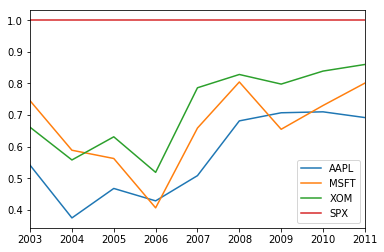

In [60]:
# f,ax = plt.subplots(1)
#ax.plot(a.index,'AAPL',data=a)
a.plot()

In [61]:
#두 컬럼간의 연산도 가능
rets.groupby(get_year).apply(lambda x:x['AAPL'].corr(x['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

### 10.3.6. 예제 : 그룹상의 선형회귀  
statsmodels를 사용해서 그룹마다 최소제곱으로 회귀수행하기

In [62]:
import statsmodels.api as sm
#Ordinary Least Squares, OLS
def regress(data,yvar,xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y,X).fit()
    return result.params
rets.groupby(get_year).apply(regress,'AAPL',['SPX'])

,SPX,intercept
2003,1.195406,0.000710
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514


## 10.4. 피벗테이블과 교차일람표  
데이터를 하나 이상의 키로 수집해서 어떤키는 행에 어떤키는 열에 정렬함  
groupby를 위한 인터페이스를 제공하기 위해 마진이라는 부분합을 추가하는 기능 제공

In [63]:
tips.head()

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808


In [64]:
tips.pivot_table(index=['day','smoker']) #그룹 평균이 나옴

size       tip   tip_pct  total_bill
day  smoker                                          
Fri  No      2.250000  2.812500  0.151650   18.420000
     Yes     2.066667  2.714000  0.174783   16.813333
Sat  No      2.555556  3.102889  0.158048   19.661778
     Yes     2.476190  2.875476  0.147906   21.276667
Sun  No      2.929825  3.167895  0.160113   20.506667
     Yes     2.578947  3.516842  0.187250   24.120000
Thur No      2.488889  2.673778  0.160298   17.113111
     Yes     2.352941  3.030000  0.163863   19.190588

In [65]:
#tip_pct와 size에 대해서만 집계하고 날짜별로 그룹
tips.pivot_table(['tip_pct','size'],index=['time','day'],columns=['smoker'])

size             tip_pct          
smoker             No       Yes        No       Yes
time   day                                         
Dinner Fri   2.000000  2.222222  0.139622  0.165347
       Sat   2.555556  2.476190  0.158048  0.147906
       Sun   2.929825  2.578947  0.160113  0.187250
       Thur  2.000000       NaN  0.159744       NaN
Lunch  Fri   3.000000  1.833333  0.187735  0.188937
       Thur  2.500000  2.352941  0.160311  0.163863

In [66]:
#margins = True로 넘기면 부분합도 구해줌
tips.pivot_table(['tip_pct','size'],index=['time','day'],columns=['smoker'], margins=True)

size                       tip_pct                    
smoker             No       Yes       All        No       Yes       All
time   day                                                             
Dinner Fri   2.000000  2.222222  2.166667  0.139622  0.165347  0.158916
       Sat   2.555556  2.476190  2.517241  0.158048  0.147906  0.153152
       Sun   2.929825  2.578947  2.842105  0.160113  0.187250  0.166897
       Thur  2.000000       NaN  2.000000  0.159744       NaN  0.159744
Lunch  Fri   3.000000  1.833333  2.000000  0.187735  0.188937  0.188765
       Thur  2.500000  2.352941  2.459016  0.160311  0.163863  0.161301
All          2.668874  2.408602  2.569672  0.159328  0.163196  0.160803

다른 집계함수를 사용하려면 aggfunc로 넘기면됨

In [67]:
tips.pivot_table(['tip_pct'],index=['time','smoker'],columns='day',margins=True)
print('-------------------------')
print('len함수 적용')
tips.pivot_table(['tip_pct'],index=['time','smoker'],columns='day',margins=True,aggfunc=len)
print('-------------------------')
print('"count"함수 적용')
tips.pivot_table(['tip_pct'],index=['time','smoker'],columns='day',margins=True,aggfunc='count')
print('-------------------------')
print('fill_value 옵션')
tips.pivot_table(['tip_pct'],index=['time','smoker'],columns='day',margins=True,aggfunc='count',fill_value=50)

tip_pct                                        
day                 Fri       Sat       Sun      Thur       All
time   smoker                                                  
Dinner No      0.139622  0.158048  0.160113  0.159744  0.158653
       Yes     0.165347  0.147906  0.187250       NaN  0.160828
Lunch  No      0.187735       NaN       NaN  0.160311  0.160920
       Yes     0.188937       NaN       NaN  0.163863  0.170404
All            0.169913  0.153152  0.166897  0.161276  0.160803

-------------------------
len함수 적용


tip_pct                         
day               Fri   Sat   Sun  Thur    All
time   smoker                                 
Dinner No         3.0  45.0  57.0   1.0  106.0
       Yes        9.0  42.0  19.0   NaN   70.0
Lunch  No         1.0   NaN   NaN  44.0   45.0
       Yes        6.0   NaN   NaN  17.0   23.0
All              19.0  87.0  76.0  62.0  244.0

-------------------------
"count"함수 적용


tip_pct                       
day               Fri   Sat   Sun  Thur  All
time   smoker                               
Dinner No         3.0  45.0  57.0   1.0  106
       Yes        9.0  42.0  19.0   NaN   70
Lunch  No         1.0   NaN   NaN  44.0   45
       Yes        6.0   NaN   NaN  17.0   23
All              19.0  87.0  76.0  62.0  244

-------------------------
fill_value 옵션


tip_pct                  
day               Fri Sat Sun Thur  All
time   smoker                          
Dinner No           3  45  57    1  106
       Yes          9  42  19   50   70
Lunch  No           1  50  50   44   45
       Yes          6  50  50   17   23
All                19  87  76   62  244

### 10.4.1 교차일람표  
교차일람표 : 그룹빈도를 계산하기위한 특수한 경우

In [68]:
#pivot_table 사용할수도 있지만 crosstab이 더 편리함
pd.crosstab([tips.time,tips.day],tips.smoker,margins=True)
tips.pivot_table(columns='smoker',index=['time','day'],margins=True,aggfunc='count')

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244

size               tip            tip_pct            total_bill  \
smoker          No   Yes  All     No   Yes  All      No   Yes  All         No   
time   day                                                                      
Dinner Fri     3.0   9.0   12    3.0   9.0   12     3.0   9.0   12        3.0   
       Sat    45.0  42.0   87   45.0  42.0   87    45.0  42.0   87       45.0   
       Sun    57.0  19.0   76   57.0  19.0   76    57.0  19.0   76       57.0   
       Thur    1.0   NaN    1    1.0   NaN    1     1.0   NaN    1        1.0   
Lunch  Fri     1.0   6.0    7    1.0   6.0    7     1.0   6.0    7        1.0   
       Thur   44.0  17.0   61   44.0  17.0   61    44.0  17.0   61       44.0   
All          151.0  93.0  244  151.0  93.0  244   151.0  93.0  244      151.0   

                        
smoker        Yes  All  
time   day              
Dinner Fri    9.0   12  
       Sat   42.0   87  
       Sun   19.0   76  
       Thur   NaN    1  
Lunch  Fri    6.0    7  
       Thur  17.0   61  
All          93.0  244